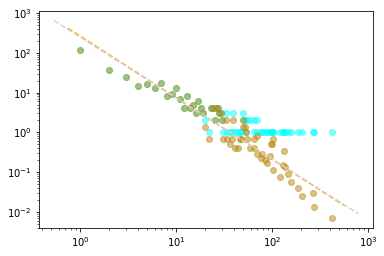

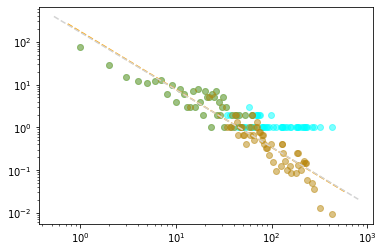

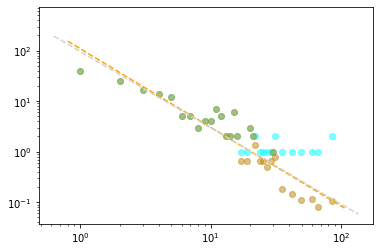

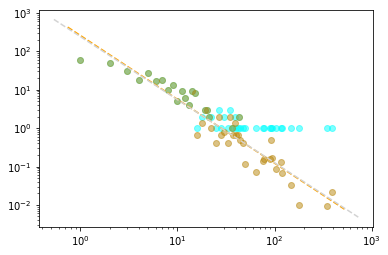

In [1]:
# https://github.com/jbhoosreddy/spellcorrect/
# https://www.cs.ubc.ca/~carenini/TEACHING/CPSC503-04/spelling90.pdf
# https://pdfs.semanticscholar.org/3c0f/046634f8102c2acb495aaf7f14924c2d4ee7.pdf
# https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib

import ast
from collections import Counter, defaultdict
import numpy as np
np.set_printoptions(linewidth=1000, precision=6, suppress=True)
np.random.seed(0)
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
import pandas as pd

def abline(axes, slope, intercept, c):
    x_vals = np.array(axes.get_xlim())
    y_vals = np.exp(intercept + slope * np.log(x_vals))
    plt.plot(x_vals, y_vals, '--', c=c)
    
def letter_to_coord(a, i):
    if a == '#':
        return 0
    return ord(a) - ord('a') + i

edits = ['add', 'del', 'rev', 'sub']
editmatrices = {}
origeditmatrices = {}

for i, edit in enumerate(edits):
    with open(edit + 'confusion.data', 'r') as f:
        C = f.read()
        f.close
    C = ast.literal_eval(C)  
    
    N = sum(C.values())

    C = dict(sorted(C.items(), key=lambda x: x[1]))

    N_c = Counter()
    for pair, c in C.items():
        if (pair[0] != pair[1]) or (edit in ['add', 'del']) or (c > 0):
            N_c[c] += 1

    assert N_c[0] > 0
    assert N == sum([c * n for c, n in N_c.items()])

    R = list(N_c.keys())
    N_r = list(N_c.values())
    Z = {R[i]: N_r[i] / (0.5 * (R[i + 1] - R[i - 1])) for i in range(1, len(N_c) - 1)}
    Z[R[-1]] = N_r[-1] / (R[-1] - R[-2])
    
    fig = plt.figure()
    ax = plt.gca()
    ax.scatter(list(N_c.keys()), list(N_c.values()), c='cyan', alpha=0.5)
    ax.scatter(list(Z.keys()), list(Z.values()), c='darkgoldenrod', alpha=0.5)
    ax.set_yscale('log')
    ax.set_xscale('log')

    x = np.log(list(Z.keys())).reshape(-1, 1)
    y = np.log(list(Z.values())).reshape(-1, 1)
    c = ['orange', 'lightgray']
    for i, regr in enumerate([LinearRegression(), Ridge()]):
        regr.fit(x, y)
        a_, b_ = regr.intercept_[0], regr.coef_[0][0]
        assert b_ < -1, b_
        abline(ax, b_, a_, c[i])
    
    N_ = lambda r: np.exp(regr.predict(np.log(r).reshape(1, -1)))
    SGT = {}
    for r in R[1:]:
        r_ = r * np.power((1 + 1 / r), (b_ + 1))
        N_rp1 = N_(r + 1)
        N_r = N_(r)
        assert np.isclose(r_, (r + 1) *  N_rp1 / N_r)
        assert r > r_
        std = (r + 1) * np.sqrt(N_rp1 * (1 + N_rp1 / N_r)) / N_r
        if r - r_ > 1.65 * std:
            SGT[r] = r_
        else:
            SGT[r] = r
    
    default_value = N_c[1] / N
    unnorm = sum(SGT.values())
    P_r = {r: (1 - default_value) * SGT[r] / unnorm for r in SGT}
    P_r[0] = default_value
    
    index = set()
    columns = set()
    for pair in C:
        index.add(pair[0])
        columns.add(pair[1])
    index = pd.Index(sorted(index))
    columns = pd.Index(sorted(columns))
    
    matrix = np.ones((index.size, columns.size))
    origmatrix = np.zeros((index.size, columns.size))

    for pair, c in C.items():
        if (pair[0] != pair[1]) or (edit in ['add', 'del']) or (c > 0):
            if edit in ['add', 'del']:
                i = letter_to_coord(pair[0], 1)
            else:
                i = letter_to_coord(pair[0], 0)
            j = letter_to_coord(pair[1], 0)
            matrix[i][j] = P_r[C[pair]] / N_c[C[pair]]
            origmatrix[i][j] = C[pair]
    
    total_probability = matrix[matrix != 1].sum()
    assert np.isclose(total_probability, 1), total_probability
    
    matrix = -np.log(matrix)
    matrix /= matrix.mean()
        
    matrix = pd.DataFrame(matrix, index=index, columns=columns)
    origmatrix = pd.DataFrame(origmatrix, index=index, columns=columns)
    
    editmatrices[edit] = matrix
    origeditmatrices[edit] = origmatrix

In [2]:
import re

def MinEditDistance(x, y, dasr, editmatrices=None):
    
    dasr = np.array(dasr)
    
    x = '#' + re.sub('[^a-z]', '', x.lower())
    y = '#' + re.sub('[^a-z]', '', y.lower())
    m = len(x)
    n = len(y)
    
    # initialize edit distance matrix
    D = np.zeros((m, n))
    D[:, 0] = np.arange(m)
    D[0, :] = np.arange(n)
    
    # initialize backtrace matrix
    backtrace = np.empty((m - 1, n - 1, 4))
    
    # compute recurrence relations
    for i in range(1, m):
        for j in range(1, n):
            if editmatrices is None:
                down = D[i - 1, j] + dasr[0]
                left = D[i, j - 1] + dasr[1]
                diag = D[i - 1, j - 1] + dasr[2] * (x[i] != y[j])
                swap = None
                if (x[i - 1] == y[j]) and (x[i] == y[j - 1]):
                    swap = D[i - 2, j - 2] + dasr[3]
            else:
                # compute distances using lookup tables
                down = D[i - 1, j] + dasr[0] * editmatrices['del'][x[i]][y[j]]
                left = D[i, j - 1] + dasr[1] * editmatrices['add'][x[i]][y[j]]
                diag = D[i - 1, j - 1] + dasr[2] * editmatrices['sub'][x[i]][y[j]]
                swap = None
                if (x[i - 1] == y[j]) and (x[i] == y[j - 1]):
                    swap = D[i - 2, j - 2] + dasr[3] * editmatrices['rev'][x[i]][y[j]]
            # assign minimum distance to current cell
            if swap is None:
                D[i, j] = min(left, down, diag)
            else:
                D[i, j] = min(left, down, diag, swap)
            # backtrace from current cell to previous cells
            backtrace[i - 1][j - 1] = [D[i, j] == left, D[i, j] == down,
                                       D[i, j] == diag, D[i, j] == swap]

    # divide D by one plus the harmonic mean of the coefficients raised to Viswanath's
    # constant
    hmean = 1 / (1 / dasr).mean()
    D /= 6.8777088079702935 * hmean**1.1319882487943 / 8
        
#     print(np.flipud(D))
    
    # return value is the final minimum edit distnce D(m,n)
    out = D[m - 1, n - 1]
    
    return out, backtrace

d1, _ = MinEditDistance('intention', 'execution', [1, 1, 2, 1])
d2, _ = MinEditDistance('intention', 'execution', [1, 1, 2, 1], editmatrices=editmatrices)
d1, d2

(8.0, 4.997020372856373)

In [3]:
# List obtained from https://www.lexico.com/grammar/common-misspellings,
# plus a few of my own
# There is certainly room for improvement!
wordpairs = [
 ('Carribean', 'Caribbean'),
 ('Farenheit', 'Fahrenheit'),
 ('Neandertal', 'Neanderthal'),
 ('Portugese', 'Portuguese'),
 ('accomodate', 'accommodate'),
 ('accomodation', 'accommodation'),
 ('accross', 'across'),
 ('acheive', 'achieve'),
 ('agression', 'aggression'),
 ('agressive', 'aggressive'),
 ('apparant', 'apparent'),
 ('apparantly', 'apparently'),
 ('appearence', 'appearance'),
 ('arguement', 'argument'),
 ('armour', 'armor'),
 ('assasin', 'assassin'),
 ('assasination', 'assassination'),
 ('basicly', 'basically'),
 ('begining', 'beginning'),
 ('beleive', 'believe'),
 ('belive', 'believe'),
 ('bizzare', 'bizarre'),
 ('buisness', 'business'),
 ('calender', 'calendar'),
 ('cemetary', 'cemetery'),
 ('chauffer', 'chauffeur'),
 ('collegue', 'colleague'),
 ('colour', 'color'),
 ('comittee', 'committee'),
 ('comming', 'coming'),
 ('commitee', 'committee'),
 ('completly', 'completely'),
 ('concievable', 'conceivable'),
 ('concievably', 'conceivably'),
 ('concious', 'conscious'),
 ('counciled', 'counselled'),
 ('curiousity', 'curiosity'),
 ('definately', 'definitely'),
 ('dilemna', 'dilemma'),
 ('dissapear', 'disappear'),
 ('dissapoint', 'disappoint'),
 ('ecstacy', 'ecstasy'),
 ('embarass', 'embarrass'),
 ('enviroment', 'environment'),
 ('existance', 'existence'),
 ('experiance', 'experience'),
 ('familar', 'familiar'),
 ('finaly', 'finally'),
 ('florescent', 'fluorescent'),
 ('foriegn', 'foreign'),
 ('forseeable', 'foreseeable'),
 ('fourty', 'forty'),
 ('foward', 'forward'),
 ('freind', 'friend'),
 ('futher', 'further'),
 ('gaurd', 'guard'),
 ('glamourous', 'glamorous'),
 ('goverment', 'government'),
 ('greive', 'grieve'),
 ('happend', 'happened'),
 ('harrass', 'harass'),
 ('harrassment', 'harassment'),
 ('honourary', 'honorary'),
 ('humourous', 'humorous'),
 ('idiosyncracy', 'idiosyncrasy'),
 ('immediatly', 'immediately'),
 ('incidently', 'incidentally'),
 ('inconcievable', 'inconceivable'),
 ('inconcievably', 'inconceivably'),
 ('independant', 'independent'),
 ('ingenius', 'ingenious'),
 ('interupt', 'interrupt'),
 ('irresistable', 'irresistible'),
 ('jist', 'gist'),
 ('knowlege', 'knowledge'),
 ('liase', 'liaise'),
 ('liason', 'liaison'),
 ('lollypop', 'lollipop'),
 ('millenia', 'millennia'),
 ('millenium', 'millennium'),
 ('neccessary', 'necessary'),
 ('noticable', 'noticeable'),
 ('ocassion', 'occasion'),
 ('occassion', 'occasion'),
 ('occurance', 'occurrence'),
 ('occured', 'occurred'),
 ('occurence', 'occurrence'),
 ('occuring', 'occurring'),
 ('pavillion', 'pavilion'),
 ('peice', 'piece'),
 ('percieve', 'perceive'),
 ('persistant', 'persistent'),
 ('pharoah', 'pharaoh'),
 ('politican', 'politician'),
 ('posession', 'possession'),
 ('prefered', 'preferred'),
 ('prefering', 'preferring'),
 ('propoganda', 'propaganda'),
 ('publically', 'publicly'),
 ('realy', 'really'),
 ('recieve', 'receive'),
 ('recieved', 'received'),
 ('refered', 'referred'),
 ('refering', 'referring'),
 ('religous', 'religious'),
 ('rember', 'remember'),
 ('remeber', 'remember'),
 ('resistence', 'resistance'),
 ('seige', 'siege'),
 ('sence', 'sense'),
 ('seperate', 'separate'),
 ('succesful', 'successful'),
 ('supercede', 'supersede'),
 ('suprise', 'surprise'),
 ('tatoo', 'tattoo'),
 ('tendancy', 'tendency'),
 ('therefor', 'therefore'),
 ('threshhold', 'threshold'),
 ('tomarrow', 'tomorrow'),
 ('tommorow', 'tomorrow'),
 ('tommorrow', 'tomorrow'),
 ('tounge', 'tongue'),
 ('truely', 'truly'),
 ('unforseen', 'unforeseen'),
 ('unfortunatly', 'unfortunately'),
 ('untill', 'until'),
 ('whereever', 'wherever'),
 ('wich', 'which'),
 ('wierd', 'weird')
]

In [4]:
def get_minedits(a, b, n, dasr, lr):
    x = np.empty(n**4).reshape(n, n, n, n)
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    dasr0 = dasr + np.array([i, j, k, l]) * lr
                    dasr0 /= dasr0.sum()
                    x[i][j][k][l], _ = MinEditDistance(a, b, dasr0, editmatrices)
    return x

# dasr should converge to (approximately) the same result regardless of starting values,
# and the loss should never increase.
def optimize_dasr(dasr_init):
    dasr = dasr_init / dasr_init.sum()
    print(dasr)
    lr = 0.05
    loss = None
    for n in range(50):
        x = []
        for wordpair in wordpairs:
            x.append(get_minedits(wordpair[0], wordpair[1], 2, dasr, lr))
        x = np.mean(x, axis=0)
        if loss is not None:
            assert np.min(x) <= loss, np.min(x)
        loss = np.min(x)
        result = np.array(np.unravel_index(np.argmin(x), x.shape))
        dasr += result * lr
        dasr /= dasr.sum()
        print(loss, dasr)
        if result.sum() == 0:
            break
        lr *= 0.9
    return dasr, loss

In [5]:
dasr_loss = []
dasr_loss.append(optimize_dasr(np.ones(4)))
dasr_loss.append(optimize_dasr(np.random.rand(4)))
dasr_loss.append(optimize_dasr(np.random.rand(4)))
dasr_loss.append(optimize_dasr(np.random.rand(4)))
dasr_loss.append(optimize_dasr(np.random.rand(4)))
dasr_loss = np.array(dasr_loss)
dasr_loss[np.argmin(dasr_loss[:, 1])]

[0.25 0.25 0.25 0.25]
0.743153459308224 [0.26087  0.217391 0.26087  0.26087 ]
0.7222292672985848 [0.269489 0.191534 0.269489 0.269489]
0.7094794861930783 [0.249296 0.177182 0.286761 0.286761]
0.701768660062992 [0.240528 0.170951 0.276676 0.311844]
0.6969344230346914 [0.256504 0.160426 0.259641 0.323429]
0.6940683338325891 [0.242202 0.151481 0.273043 0.333274]
0.6926317055998719 [0.235933 0.14756  0.265975 0.350532]
0.6923432065361813 [0.230423 0.144113 0.259763 0.365701]
0.6923432065361813 [0.230423 0.144113 0.259763 0.365701]
[0.227568 0.296556 0.249938 0.225938]
0.7927224554489026 [0.241363 0.257875 0.260816 0.239946]
0.7555566041138523 [0.252302 0.227203 0.269441 0.251054]
0.7322700987181611 [0.261081 0.202588 0.276363 0.259968]
0.7181876343152612 [0.268203 0.182619 0.281979 0.267199]
0.7081330017264287 [0.259684 0.176818 0.273022 0.290475]
0.7019763090149217 [0.252237 0.171747 0.265193 0.310823]
0.6979392245261117 [0.239508 0.163081 0.277042 0.320369]
0.6950518943185957 [0.251399 0

array([array([0.233291, 0.144426, 0.262198, 0.360085]), 0.6923012273700423], dtype=object)